In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

In [2]:
celeba_dir = Path('../datasets/CelebA')
label_path = celeba_dir / 'Anno/identity_CelebA.txt'
df = pd.read_csv(label_path, sep='\s+', names=['filename', 'label'])
df

,filename,label
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295
...,...,...
202594,202595.jpg,9761
202595,202596.jpg,7192
202596,202597.jpg,9852
202597,202598.jpg,5570


In [4]:
celeba_dir = Path('../datasets/CelebA')
label_txt = celeba_dir / "Anno/list_attr_celeba.txt"
attr_df = pd.read_csv(str(label_txt), sep='\s+', skiprows=1, usecols=['Male'])
attr_df

,Male
000001.jpg,-1
000002.jpg,-1
000003.jpg,1
000004.jpg,-1
000005.jpg,-1
...,...
202595.jpg,-1
202596.jpg,1
202597.jpg,1
202598.jpg,-1


In [5]:
# 加载图片
img_dir = celeba_dir / 'Img/img_align_celeba'
img_dir = img_dir.resolve()


def load_img(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  #此处的image取值[0, 255)
    return image, label


# ds_files_labels = tf.data.Dataset.from_tensor_slices((attr_df.index, attr_df.Male))
# ds_images_labels = ds_files_labels.map(load_and_process)

# 划分训练集、验证集、测试集
partition_txt = celeba_dir / 'Eval/list_eval_partition.txt'
partition_df = pd.read_csv(partition_txt, sep='\s+', names=['img_name', 'sign'])
train_idx = partition_df.loc[partition_df.sign == 0, 'img_name']
valid_idx = partition_df.loc[partition_df.sign == 1, 'img_name']
test_idx = partition_df.loc[partition_df.sign == 2, 'img_name']


def split_dataset(idx):
    """idx就是图片名字"""
    # 拼接图片路径
    img_paths = [str(img_dir / i) for i in idx]
    labels = attr_df.loc[idx, 'Male']
    labels = list(map(lambda x: 1 if x == 1 else 0, labels))
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    return ds.map(load_img)


celeba_train = split_dataset(train_idx)
celeba_valid = split_dataset(valid_idx)
celeba_test = split_dataset(test_idx)

# 此处只取部分
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

In [6]:
def preprocess(image, label, size=(64, 64), mode='train'):
    if mode == 'train':
        image_cropped = tf.image.random_crop(image, (178, 178, 3))
        image_resized = tf.image.resize(image_cropped, size)
        image_flip = tf.image.random_flip_left_right(image_resized)
        return image_flip / 255., tf.cast(label, tf.int32)

    else:
        image_cropped = tf.image.crop_to_bounding_box(image, 20, 0, 178, 178)
        image_resized = tf.image.resize(image_cropped, size)
        return image_resized / 255., tf.cast(label, tf.int32)


BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)


ds_train = celeba_train.map(
    lambda X, y: preprocess(X, y, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda X, y: preprocess(X, y, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

ds_test = celeba_test.map(
    lambda X, y: preprocess(X, y, size=IMAGE_SIZE, mode='eval'))
ds_test = ds_test.batch(BATCH_SIZE)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None)
])

tf.random.set_seed(1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid, epochs=20)

Epoch 1/20
500/500 [==============================] - 34s 49ms/step - loss: 0.6545 - accuracy: 0.5994 - val_loss: 0.5891 - val_accuracy: 0.6100
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.5410 - accuracy: 0.7075 - val_loss: 0.4866 - val_accuracy: 0.7390
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.4954 - accuracy: 0.7449 - val_loss: 0.4948 - val_accuracy: 0.6470
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.4574 - accuracy: 0.7694 - val_loss: 0.4236 - val_accuracy: 0.7280
Epoch 5/20
500/500 [==============================] - 14s 26ms/step - loss: 0.4144 - accuracy: 0.7997 - val_loss: 0.3545 - val_accuracy: 0.8280
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3954 - accuracy: 0.8110 - val_loss: 0.4374 - val_accuracy: 0.7260
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3693 - accuracy: 0.8247 - val_loss: 0.4002 - val_accuracy:

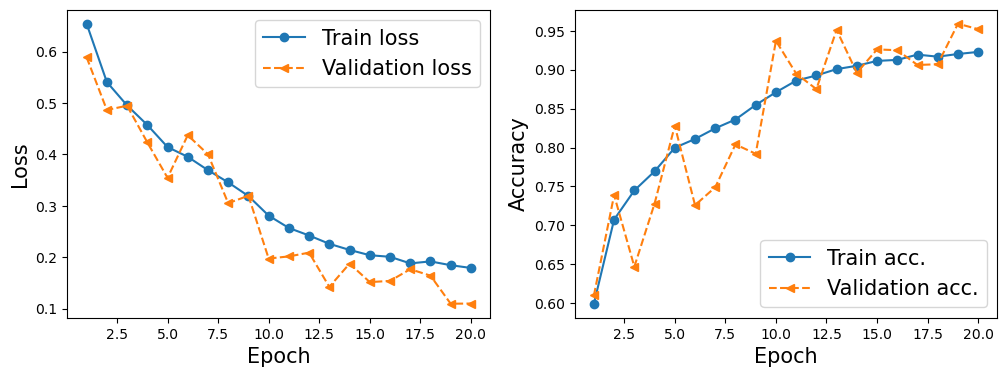

In [8]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

In [9]:
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 94.15%


In [10]:
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20)

Epoch 21/30
500/500 [==============================] - 12s 23ms/step - loss: 0.1734 - accuracy: 0.9236 - val_loss: 0.1076 - val_accuracy: 0.9540
Epoch 22/30
500/500 [==============================] - 12s 23ms/step - loss: 0.1729 - accuracy: 0.9258 - val_loss: 0.1095 - val_accuracy: 0.9530
Epoch 23/30
500/500 [==============================] - 12s 23ms/step - loss: 0.1676 - accuracy: 0.9270 - val_loss: 0.1177 - val_accuracy: 0.9550
Epoch 24/30
500/500 [==============================] - 12s 24ms/step - loss: 0.1686 - accuracy: 0.9304 - val_loss: 0.1090 - val_accuracy: 0.9590
Epoch 25/30
500/500 [==============================] - 12s 24ms/step - loss: 0.1639 - accuracy: 0.9295 - val_loss: 0.1035 - val_accuracy: 0.9590
Epoch 26/30
500/500 [==============================] - 12s 24ms/step - loss: 0.1586 - accuracy: 0.9339 - val_loss: 0.1110 - val_accuracy: 0.9500
Epoch 27/30
500/500 [==============================] - 12s 24ms/step - loss: 0.1573 - accuracy: 0.9307 - val_loss: 0.1089 - val_ac

In [11]:
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 94.54%


这个没有采用repeat()方法，只制指定了batch_size

In [12]:
model.save('models/celeba-cnn2.h5')